(600, 2)

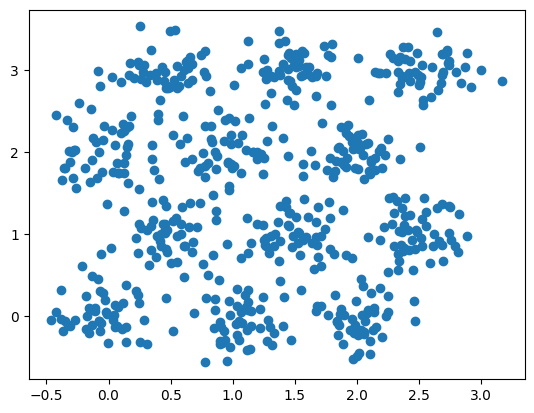

In [449]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from time import perf_counter as tick


plt.style.use('default')

w, h = 4, 3
c = [(i + 0.5*(j%2), j) for i in range(h) for j in range(w)]
data = []
for center in c:
    new_data = np.random.multivariate_normal(center, 0.05*np.eye(len(center)), 50)
    # print(new_data[:5])
    data.append(new_data)
k = h*w

X = np.concatenate(data, axis=0)

plt.scatter(X[:, 0], X[:, 1])
X.shape

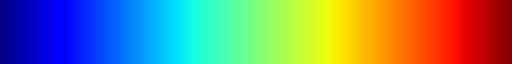

In [450]:
cmap = plt.get_cmap('jet')
cmap

In [451]:
def centroids_initialize(X, k, method='random_point'):
    if method == 'random_point':
        indices = [i for i in range(len(X))]
        C_indices = np.random.choice(indices, k, replace=False)
        C = X[C_indices]
    elif method == "random_location":
        min_x = X.min(axis=0)
        max_x = X.max(axis=0)
        C = np.random.uniform(min_x, max_x, [k, len(min_x)])
    # TODO: K-means++
    elif method == "K-means++":
        pass
    else:
        raise NotImplementedError(f"Centroid initialize method '{method}' is invalid. ")
    
    return C

In [452]:
def K_means_online(X, centroids=None, max_iter=10, ratio_threshold=0.01):
    '''
    After each assignment to x_i, immediately update new and old centroids by incremental method. 
    '''
    # initialize centroids
    if isinstance(centroids, int) or (isinstance(centroids, np.ndarray) and centroids.ndim == 0):  # only know number of clusters
        k = centroids
        C = centroids_initialize(X, k)
    else:  # centroids are specified
        # move centroids to nearest point
        k = len(centroids)
        C = np.array(centroids)
    
    n = len(X)
    labels = np.array([-1] * n)
    
    # online K-means: maintain n of each cluster
    C_num_points = [0] * k
    # num_points[C_indices] = 1
    
    ratio_threshold = 0.01
    step = 0
    for _ in range(max_iter):
        indices = [i for i in range(n)]
        np.random.shuffle(indices)  # in-place operation
        
        C_ = C.copy()  # old centroids in last iter
        labels_old = labels.copy()
        for i in indices:
            point = X[i]
            distance = np.linalg.norm(C - point, axis=1)  # (k, d) -> (k)
            c_old = labels[i]
            c = distance.argmin()
            labels[i] = c  # update label for current point
            
            if c_old == c:
                continue
            
            # update new centroid
            n_j = C_num_points[c]
            C[c] = (n_j * C[c] + point) / (n_j + 1)
            C_num_points[c] += 1
            
            # update old centroid
            if c_old == -1:  # classified point
                continue
            n_j_ = C_num_points[c_old]
            C[c_old] = (n_j_ * C[c_old] - point) / (n_j_ - 1)
            C_num_points[c_old] -= 1
            assert C_num_points[c_old] > 0
        
        step += 1
        # if (np.linalg.norm(C - C_, axis=1) < threshold).all():
        if (labels_old != labels).sum() < n * ratio_threshold:
            break
    
    print(f"Steps: {step}")
    return labels, C

Steps: 2
Steps: 2


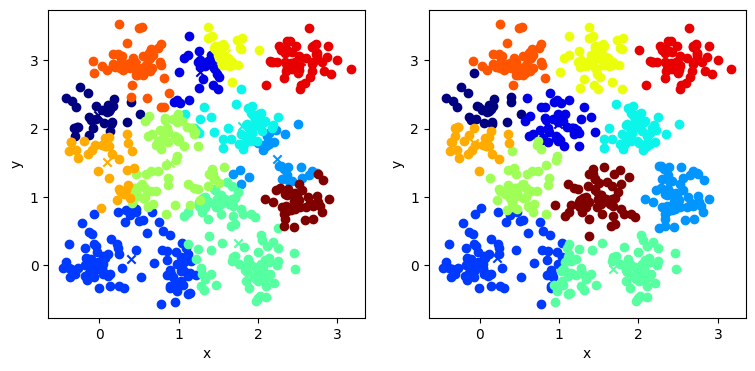

0.0008, 0.0064


In [466]:
def K_means(X, centroids=None, max_iter=10, ratio_threshold=0.01):
    # initialize centroids
    if isinstance(centroids, int) or (isinstance(centroids, np.ndarray) and centroids.ndim == 0):  # only know number of clusters
        k = centroids
        C = centroids_initialize(X, k)
    else:  # centroids are specified
        # move centroids to nearest point
        k = len(centroids)
        C = np.array(centroids)
    
    n = len(X)
    labels = [-1] * n
    
    step = 0
    for _ in range(max_iter):
        step += 1
        distance = np.linalg.norm(X[..., None] - C.T[None, ...], axis=1)  # (n, d, k) -> (n, k)
        labels_old = labels.copy()
        labels = distance.argmin(axis=1)
        
        # update centroids
        C_ = C.copy()
        C = np.array([X[labels == c].mean(axis=0) for c in range(k)])
        
        # use shift distance of centroids is not good, because we don't know data's scale
        # if (np.linalg.norm(C - C_, axis=1) < threshold).all():
        if (labels_old != labels).sum() < n * ratio_threshold:
            break
    
    print(f"Steps: {step}")
    return labels, C


def plot(X, centroids, labels, cmap='jet'):
    if X.shape[1] != 2:
        return
    
    classes = np.unique(labels)
    classes.sort()
    
    # get color map
    norm = matplotlib.colors.Normalize(vmin=0, vmax=len(classes) - 1)
    cmap = plt.get_cmap(cmap)
    mappable = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)
    
    for i in range(len(classes)):
        color = mappable.to_rgba(i)
        plt.scatter(centroids[i][0], centroids[i][1], color=color, marker='x')
        X_c = X[labels == classes[i]]
        plt.scatter(X_c[:, 0], X_c[:, 1], color=color)
    
    plt.xlabel('x')
    plt.ylabel('y')

max_iter = 2
ratio_threshold = 0
C = centroids_initialize(X, k)

plt.figure(figsize=(9, 4))
plt.subplot(1, 2, 1)
t1 = tick()
labels, C = K_means(X, C, max_iter=max_iter, ratio_threshold=ratio_threshold)
t2 = tick()
plot(X, C, labels)

plt.subplot(1, 2, 2)
t3 = tick()
labels, C = K_means_online(X, C, max_iter=max_iter, ratio_threshold=ratio_threshold)
t4 = tick()
plot(X, C, labels)

plt.show()

print(f"{t2-t1:.4f}, {t4-t3:.4f}")

In [ ]:
def K_means_slow(X, centroids=None, max_iter=10, ratio_threshold=0.01):
    # initialize centroids
    if isinstance(centroids, int) or (isinstance(centroids, np.ndarray) and centroids.ndim == 0):  # only know number of clusters
        k = centroids
        C = centroids_initialize(X, k)
    else:  # centroids are specified
        # move centroids to nearest point
        k = len(centroids)
        C = np.array(centroids)
    
    n = len(X)
    labels = [-1] * n
    
    step = 0
    for _ in range(max_iter):
        step += 1
        distance = np.zeros((n, k))
        for i in range(n):
            for j in range(k):
                distance[i, j] = np.linalg.norm(X[i] - C[j])
        labels_old = labels.copy()
        labels = distance.argmin(axis=1)
        
        # update centroids
        C_ = C.copy()
        C = np.array([X[labels == c].mean(axis=0) for c in range(k)])
        
        # use shift distance of centroids is not good, because we don't know data's scale
        # if (np.linalg.norm(C - C_, axis=1) < threshold).all():
        if (labels_old != labels).sum() < n * ratio_threshold:
            break
    
    print(f"Steps: {step}")
    return labels, C